In [1]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr

In [3]:
file = pd.read_table('../steps/temp_disc.features', dtype=str)
CIN = pd.read_table("/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt")
CIN.head()

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,1,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,2,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,3,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,4,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,5,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [4]:
lda = LdaModel.load(f'../steps/gensim/lda/lda_t5_f10.model')
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

In [5]:
def create_heatmap(model, df):
    topics = lda.get_document_topics(bow = bow_corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df


In [6]:
weights_df = create_heatmap(lda, file)
heatmap_df = weights_df.drop('Sample', axis = 1).set_index('Chr').transpose()
heatmap_df

Chr,1,1,1,1,1,1,1,1,1,1,...,23,23,23,23,23,23,23,23,23,23
1,0.577603,0.969574,0.006071,0.006071,0.006071,0.006071,0.969574,0.969574,0.509419,0.006071,...,0.006071,0.006071,0.006071,0.006071,0.006071,0.006071,0.006071,0.006071,0.006071,0.006071
2,0.400662,0.008691,0.008691,0.008691,0.008691,0.008691,0.008691,0.008691,0.008691,0.008691,...,0.008691,0.972194,0.008691,0.972194,0.972193,0.972194,0.972194,0.008691,0.369632,0.008691
3,0.006532,0.006532,0.970034,0.970034,0.515910,0.707511,0.006532,0.006532,0.006532,0.970034,...,0.970034,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.006532,0.609093,0.006532
4,0.008711,0.008711,0.008711,0.008711,0.008711,0.271234,0.008711,0.008711,0.008711,0.008711,...,0.008711,0.008711,0.008711,0.008711,0.008711,0.008711,0.008711,0.008711,0.008711,0.008711
5,0.006493,0.006493,0.006493,0.006493,0.460617,0.006493,0.006493,0.006493,0.466648,0.006493,...,0.006493,0.006493,0.969996,0.006493,0.006493,0.006493,0.006493,0.969996,0.006493,0.969996


In [7]:
clusters = file['Chr'].unique()
palette = list(sns.color_palette("viridis", 23).as_hex())
color_mapping = dict(zip(clusters, palette))
cluster_colors = file['Chr'].map(color_mapping)

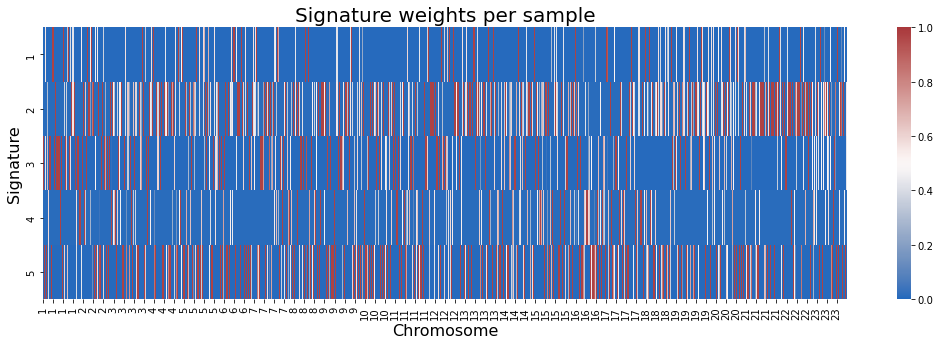

In [20]:
plt.figure(figsize=(18,5))
ax = sns.heatmap(heatmap_df, cmap='coolwarm', vmin=0, vmax=1)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Chromosome', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Signature weights per sample", fontsize=20)
plt.savefig('../figures/heatmap.pdf')
plt.show()

In [10]:
cin = CIN.set_index('bcr_patient_barcode')
cin = cin.reindex(index=weights_df['Sample'])
cin = cin.reset_index()
combined_df = weights_df.reset_index()
combined_df['Age_at_diagnosis'] = cin['age_at_initial_pathologic_diagnosis']

combined_df['Gender'] = cin['gender']
combined_df['Gender']=combined_df['Gender'].astype('category').cat.codes
combined_df = combined_df.dropna()
combined_df.head()

,index,Sample,Chr,1,2,3,4,5,Age_at_diagnosis,Gender
0,0,TCGA-02-0001,1,0.577603,0.400662,0.006532,0.008711,0.006493,44.0,0
1,55108,TCGA-AP-A054,1,0.969574,0.008691,0.006532,0.008711,0.006493,64.0,0
2,76107,TCGA-C4-A0F7,1,0.006071,0.008691,0.970034,0.008711,0.006493,77.0,1
3,99958,TCGA-DJ-A3US,1,0.006071,0.008691,0.970034,0.008711,0.006493,37.0,0
4,160885,TCGA-TS-A8AI,1,0.006071,0.008691,0.515910,0.008711,0.460617,58.0,1


In [11]:
def correlate(df, pval):
    corr_agediag = []
    corr_gender = []
    
    for i in range(1, 6):
        corr_agediag.append(pearsonr(df[f'{i}'], df['Age_at_diagnosis'])[pval])
        corr_gender.append(pearsonr(df[f'{i}'], df['Gender'])[pval])
    
    corr_df = pd.DataFrame([1, 2, 3, 4, 5], columns=['Signature'])
    corr_df['Gender'] = corr_gender
    corr_df['Age_at_diagnosis'] = corr_agediag
    corr_df = corr_df.set_index('Signature')
    corr_df = corr_df.transpose()
    
    return corr_df

In [12]:
corr_df = correlate(combined_df, 0)

<AxesSubplot:xlabel='Signature'>

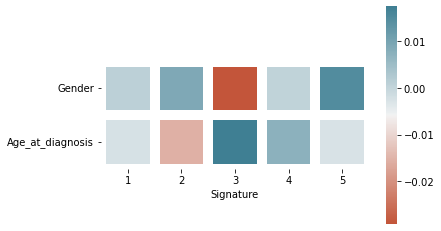

In [13]:
palette = sns.diverging_palette(20, 220, as_cmap=True)
sns.heatmap(
    corr_df, 
    # vmin=-1, vmax=1, 
    cmap=palette,
    square=True,
    linewidths=10)

In [14]:
pval_df = correlate(combined_df, 1)

<AxesSubplot:xlabel='Signature'>

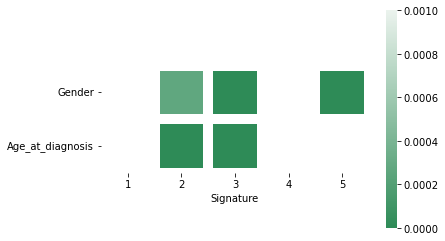

In [15]:
from matplotlib.colors import ListedColormap
palette = sns.light_palette('seagreen', reverse=True, as_cmap=True)
color = [(1,1,1)]
cmap = ListedColormap(color)
psig = 0.001

sns.heatmap(
    pval_df[pval_df<psig], 
    vmin=0, vmax=0.001, 
    cmap=palette,
    square=True,
    linewidths=10
    )
sns.heatmap(
    pval_df[pval_df>=psig], 
    cmap=cmap,
    square=True, cbar=False, 
    linewidths=10
    )